In [2]:
.libPaths(c('/anaconda2/lib/R/library',.libPaths()))
setwd("/Users/ssapkot/Documents/Experiments/SAP_GS_PopStr")

library(rrBLUP)
library(ggplot2)
library(BGLR)
require(dplyr)
require(reshape2)

install.packages("sommer",repos='http://cran.us.r-project.org')
library(sommer)

my.read.vcf <- function(file, special.char="##", ...) {
  my.search.term <- paste0(special.char, ".*")  # Making a search term that looks like: "##.*", tells R to find anything containing the pattern "##" followed by anything (* is wildcard)
  clean.lines <- sub(my.search.term, "", readLines(file)) # Replace any line containing the search term with nothing (in other words remove it)
  clean.lines2 <- sub("#CHROM", "CHROM", clean.lines) # Replace the #CHROM term in the header with CHROM, so R doesn't treat it as a special character
  read.table(..., text=paste(clean.lines2, collapse="\n")) # Pass the cleaned up lines to read.table
}

also installing the dependency ‘RcppArmadillo’

Warning message in install.packages("sommer", repos = "http://cran.us.r-project.org"):
“installation of package ‘RcppArmadillo’ had non-zero exit status”Warning message in install.packages("sommer", repos = "http://cran.us.r-project.org"):
“installation of package ‘sommer’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


ERROR: Error in library(sommer): there is no package called ‘sommer’


In [3]:
GBS=my.read.vcf(file= "data/SAP_all_taxa.vcf", header=TRUE, stringsAsFactors = TRUE, as.is=TRUE)
Y <- read.csv('data/BLUEs_pheno_all.csv', header=T, row.names = 1)

## view head of phenotype file
head(Y)

,Subpopulation,Cluster,Race,Origin,DTA,PH,GN,GW,GY,FLH,PL,BL
PI152651,Caudatum,4,0,NA,66,146.61,1286,27.32,43.95,97.00000,14.33333,57.95000
PI17548,Kafir,2,0,NA,66,214.06,1167,15.62,26.66,156.83333,22.83333,83.41667
PI24969,Durra,3,0,NA,80,182.06,1319,29.92,50.86,162.00000,13.33333,41.83333
PI329435,Mixed,1,0,NA,80,95.50,1388,15.68,30.47,65.83333,26.00000,72.58333
PI329440,Kafir,2,0,NA,69,93.61,2141,17.61,48.35,58.00000,23.83333,67.16667
PI34911,Caudatum,4,0,NA,87,179.67,1587,25.50,52.56,150.00000,14.33333,39.75000


In [4]:
f.column <- grep("FORMAT", colnames(GBS))

##Function Parse vcf file to convert to -1,0,1 format
parse.GBS <- function(x) {
  unique.x <- unique(x)
  alleles <- setdiff(unique.x,union("H","N"))
  y <- rep(0,length(x))
  y[which(x==alleles[1])] <- -1
  y[which(x==alleles[2])] <- 1
  y[which(x=="N")] <- NA
  return(y)
}

X <- apply(GBS[, -c(1:f.column)],1,parse.GBS)

####  calculate the genomic relationship matrix
A = A.mat(X)
rownames(A) <- 1:nrow(X)

In [10]:
cvf <- read.csv("Data/CVFs_CV1.csv",header=T)
head(cvf)

CV_1,CV_2,CV_3,CV_4,CV_5,CV_6,CV_7,CV_8,CV_9,CV_10,⋯,CV_91,CV_92,CV_93,CV_94,CV_95,CV_96,CV_97,CV_98,CV_99,CV_100
5,3,3,2,4,1,1,4,3,5,⋯,1,5,1,5,4,1,5,1,4,4
3,5,1,4,5,4,5,1,1,3,⋯,4,2,5,2,5,1,1,4,2,3
2,1,2,1,3,4,4,1,1,4,⋯,3,2,1,2,3,4,1,5,3,5
4,4,3,1,3,3,1,5,1,2,⋯,1,3,4,4,1,5,4,1,2,2
4,4,2,2,5,3,1,4,2,4,⋯,3,5,4,4,3,5,1,1,1,2
5,4,5,4,2,1,5,5,3,3,⋯,2,2,1,4,5,3,4,2,3,3


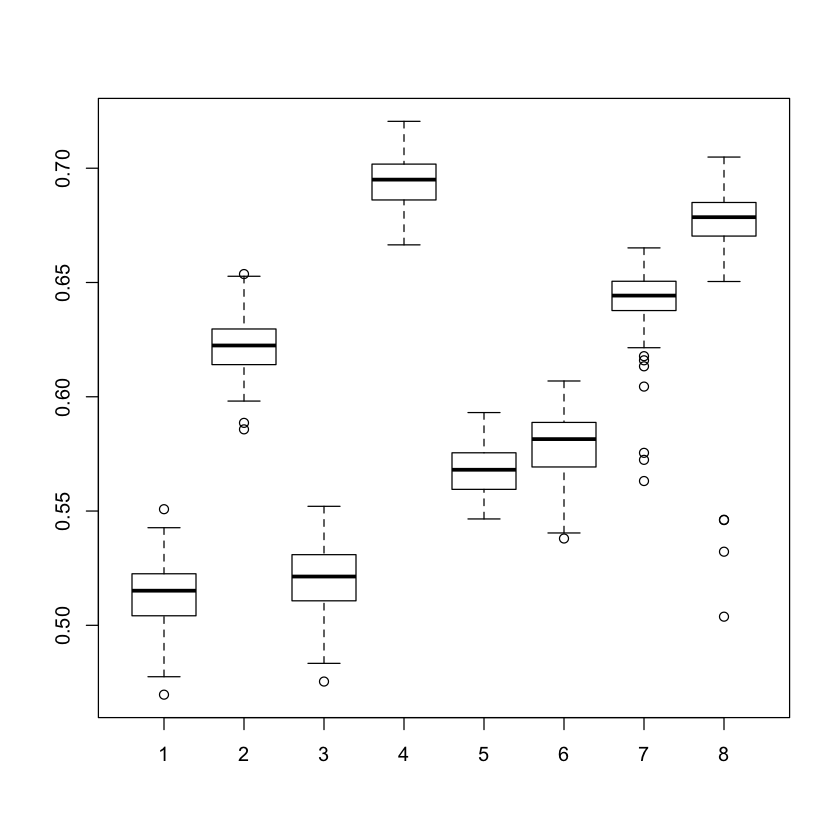

In [53]:

Pred_accuracy <- c()
Total_predValues <- c()
for (j in 5:ncol(Y)) {
corr <- c()
    PV = c()
  for (i in 1:101) {
    CV.fold <- paste("CV_",toString(i-1),sep='')
    
  if (CV.fold == "CV_0") {
    Pred_values <- c()
    corr <- c()
    }
  else {
    cvs <- cvf[,CV.fold]
  y <- Y[,j] #get vector of phenotypic values for jth phenotype
    colname = colnames(Y[j])
      
  yhat <- data.frame(cbind( y, yhat = 0))
  yhat$yhat <- as.numeric(yhat$yhat)
  row.names(yhat) <- row.names(y)
  accuracy <- c() 
  
  for(k in 1:5){ 
    # Make training (TRN) and testing (TST) dfs
    tst <- which(cvs == k)
    yNA <- y
    yNA[tst] <- NA # Mask yields for validation set
    df <- data.frame(y=yNA,gid=1:nrow(A)) # Set up dataframe with traits and genotype labels
    # Build rrBLUP model and save yhat for the masked values
    rrblup <- kin.blup(df,K=A,geno="gid",pheno="y", PEV = TRUE) #optional parameters: fixed effects, gaussian kernel, covariates
     yhat$yhat[tst] <- rrblup$pred[tst]
  }
  accuracy <- cor(yhat$y, yhat$yhat, use = "complete.obs")
    Pred_values <- cbind(Pred_values,yhat$yhat)
      corr <-  rbind(corr, accuracy)
  }
      PV = cbind(Y$Cluster, Pred_values)
}

Pred_accuracy[[j-4]] <- corr
write.csv(PV,file=paste("Predicted_Values",colname,"csv",sep="."), row.names=rowname)

}

boxplot(Pred_accuracy)

       

#### Co-variance computation

In [ ]:
##  x represents predicted values and y represents true/phenotypic values

In [55]:
BL = read.csv("CV1_predictedValues/Predicted_Values.BL.csv", header=T)
head(BL)

X,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101
PI152651,4,69.81539,69.67274,70.44681,77.78094,69.95168,72.77411,67.26445,67.27861,⋯,71.69092,69.70264,63.77554,67.43914,67.05121,71.68115,70.10315,71.80624,67.75821,72.32880
PI17548,2,119.61389,113.61321,92.81924,117.85950,92.90666,117.37790,109.14519,92.57142,⋯,111.91659,116.68576,109.48945,112.92219,111.07275,109.12732,93.44884,112.42589,117.16023,113.66021
PI24969,3,55.40242,60.73185,59.67593,58.54783,62.29088,51.66006,56.07712,61.60125,⋯,60.65119,59.10199,58.31968,55.61529,55.53363,59.30905,61.08806,59.00654,64.31867,59.04450
PI329435,1,73.54154,72.78926,70.93660,78.97326,72.61448,76.51552,77.97607,70.17900,⋯,70.70698,74.18521,75.89283,71.27292,75.52781,73.90555,72.12273,73.31100,75.81601,77.56486
PI329440,2,78.26475,73.75096,78.28207,76.58485,74.48967,77.07732,77.92547,77.05874,⋯,76.13915,78.72790,78.40313,74.69982,77.19669,76.81397,74.37383,71.50486,75.09418,70.74108
PI34911,4,54.59216,63.39166,65.46454,64.86875,66.55882,65.13947,61.87752,66.00042,⋯,60.90525,64.40621,68.47235,69.64792,67.20061,59.02793,68.36646,68.43967,58.20483,56.57009


In [88]:
Y1 = Y[Y$Cluster == 1,]
BL_mixed = BL[BL$V1==1,] ##subset  predicted values by race cluster

for (i in 1:101) {
    CV.fold <- paste("V",toString(i),sep='')
     y = Y$BL
    
  if (CV.fold == "V1") {
    Cov_mixed <- c()
    Cov_total <- c()
    E_race <- c()
      var_x = c()
      var_x1 = c()
      var_y = var(y, use = "complete.obs")
      var_y1 = var(y1, use = "complete.obs")
      Corr_CV1 = c()
      Corr_WR = c()
      
    }
  else {
      x = BL[,CV.fold]
     
      x1 = BL_mixed[,CV.fold]
      y1 = Y1$BL
    Cov_total[[i]] <- cov(x,y, use = "complete.obs") ##total covariances between prediction and true values across all individuals
    Cov_mixed[[i]] <- cov(x1,y1, use = "complete.obs") ## covariances for prediction and true values within a specified race
    
      E_race[[i]] <- Cov_total[[i]] - Cov_mixed[[i]] ## Expectation derived for Cov_total = E_race + Cov_race
      
      var_x[[i]] = var(x, use = "complete.obs") ##total variance in predicted values
      var_x1[[i]] = var(x1, use = "complete.obs") ## variance for specific race in predicted values
      Corr_CV1[[i]] = Cov_total[[i]]/sqrt(var_x[[i]]*var_y) ##correlation as a function of covariance/sqrt(variances)
      Corr_WR[[i]] = Cov_mixed[[i]]/sqrt(var_x1[[i]]*var_y1)
      }
    
    }
print("Mean of Total Covariance")
    mean(Cov_total, na.rm=T)
print("Mean of Covariance within race")
    mean(Cov_mixed, na.rm=T)
print("Mean of Expectation due to across race Covariance")
    mean(E_race,na.rm=T)
print("Mean prediction accuracy")
    mean(Corr_CV1, na.rm=T)
print("Mean prediction accuracy due to Within race component")
    mean(Corr_WR, na.rm=T)


[1] "Mean of Total Covariance"


[1] 378.6789

[1] "Mean of Covariance within race"


[1] 188.2855

[1] "Mean of Expectation due to across race Covariance"


[1] 190.3934

[1] "Mean prediction accuracy"


[1] 0.6743312

[1] "Mean prediction accuracy due to Within race component"


[1] 0.4857289

[1] 0.6697243